## **Pneumonia Detection System to locate the position of inflammation in an image**

#### **YOLO v3**

- The model has several advantages over classifier-based systems. It looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN. See our paper for more details on the full system.


In [ ]:
#Mounting Google CoLab
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
!pip install pydicom
import pydicom
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
np.random.seed(5)

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
#OpenCV and dependencies
!sudo apt-get install libopencv-dev python3-opencv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopencv-dev is already the newest version (3.2.0+dfsg-4ubuntu0.1).
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-numpy python3-opencv
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,477 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 2,477 kB in 1s (1,921 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline


**1. Clone and Build YOLOv3**

In [ ]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5946, done.
remote: Total 5946 (delta 0), reused 0 (delta 0), pack-reused 5946
Receiving objects: 100% (5946/5946), 6.37 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (3928/3928), done.


In [ ]:
#changing working directory to Darknet

%cd darknet

/content/darknet


In [ ]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

**2. Data Migration for YOLOv3**

**2.1. Make subdirectories**

In [ ]:
#Creating working directories

Project_path = "/content/drive/MyDrive/Colab Notebooks/Capstone Project/"

train_images = os.path.join(Project_path, "stage_2_train_images")
test_images = os.path.join(Project_path, "stage_2_test_images")

images_folder = os.path.join(os.getcwd(), "images")  # .jpg
labels_folder = os.path.join(os.getcwd(), "labels")  # .txt
metadata_folder = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
config_folder = os.path.join(os.getcwd(), "cfg")

# YOLOv3 training checkpoints will be saved here
backup_folder = os.path.join(os.getcwd(), "backup")

for directory in [images_folder, labels_folder, metadata_folder, config_folder, backup_folder]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [ ]:
!ls -shtl

total 2.3M
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:37 labels
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:37 metadata
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:37 images
716K -rwxr-xr-x 1 root root 714K Mar 18 07:26 darknet
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:26 obj
816K -rw-r--r-- 1 root root 814K Mar 18 07:26 libdarknet.a
612K -rwxr-xr-x 1 root root 609K Mar 18 07:26 libdarknet.so
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 results
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 backup
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 src
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 examples
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 include
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 python
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 scripts
4.0K drwxr-xr-x 3 root root 4.0K Mar 18 07:25 data
4.0K drwxr-xr-x 2 root root 4.0K Mar 18 07:25 cfg
8.0K -rw-r--r-- 1 root root 6.5K Mar 18 07:25 LICENSE.gen
 36K -rw-r--r-- 1 root root  35K Mar 18 07:25 LICENSE.gpl
4.0K -rw-r--r--

In [ ]:
Project_path

'/content/drive/MyDrive/Colab Notebooks/Capstone Project/'

**2.1. Load train labels.csv**

In [ ]:
image_annotation = pd.read_csv(os.path.join(Project_path, "stage_2_train_labels.csv"))
image_annotation.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


**2.2. Generate images and labels for training YOLOv3**

- YOLOv3 needs .txt file for each image, which contains ground truth object in the image. 
- RSNA task is binary classification.
- x and y are float values of bbox center coordinate, divided by image width and height respectively.
- w and h are width and height of bbox, divided by image width and height respectively.

- So it is different from the format of label data provided the dataset. We should change it.

In [ ]:
#Generate images and labels for training YOLOv3

def save_img_from_dcm(dcm_dir, images_folder, patient_id):
    img_fp = os.path.join(images_folder, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(images_folder, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna default image size
    img_size = 1024
    label_fp = os.path.join(labels_folder, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, images_folder, labels_folder, image_annotation):
    for row in tqdm(image_annotation.values):
        patient_id = row[0]

        img_fp = os.path.join(images_folder, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(labels_folder, patient_id, row)
            continue

        target = row[5]
        # Only files with bbox.
        if target == 0:
            continue
        save_label_from_dcm(labels_folder, patient_id, row)
        save_img_from_dcm(dcm_dir, images_folder, patient_id)

In [ ]:
import cv2

save_yolov3_data_from_rsna(train_images, images_folder, labels_folder, image_annotation)

100%|██████████| 30227/30227 [20:11<00:00, 24.95it/s]


In [ ]:
!du -sh images labels

990M	images
24M	labels


**2.3. Plot a sample train image and label**

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



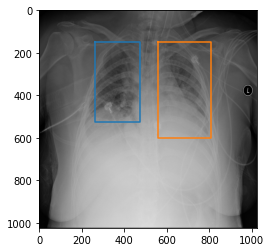

In [ ]:
sample_patient_id = image_annotation[image_annotation.Target == 1].patientId.values[0]
sample_img_path = os.path.join(images_folder, "{}.jpg".format(sample_patient_id))
sample_label_path = os.path.join(labels_folder, "{}.txt".format(sample_patient_id))

plt.imshow(cv2.imread(sample_img_path))

img_size = 1014
with open(sample_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

**2.4. Generate train and validation file path lists (.txt)**

- We should give the list of image paths to YOLO. Two seperate list textfiles for training images and validation images.

In [ ]:
def write_train_list(metadata_folder, images_folder, name, series):
    list_fp = os.path.join(metadata_folder, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(images_folder, "{}.jpg".format(patient_id)))
            f.write(line)

In [ ]:
# Following lines contain data with bbox only
patient_id_series = image_annotation[image_annotation.Target == 1].patientId.drop_duplicates()

train_series, valid_series = train_test_split(patient_id_series, test_size=0.1, random_state=5)
print("The number of train set: {}, The number of validation set: {}".format(train_series.shape[0], valid_series.shape[0]))

# train image path list
write_train_list(metadata_folder, images_folder, "train_list.txt", train_series)

# validation image path list
write_train_list(metadata_folder, images_folder, "valid_list.txt", valid_series)

The number of train set: 5410, The number of validation set: 602


**2.5. Create test image and labels for YOLOv3**

In [ ]:
#Create test images and labels for YOLOv3

def save_yolov3_test_data(test_images, images_folder, metadata_folder, name, series):
    list_fp = os.path.join(metadata_folder, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_images, images_folder, patient_id)
            line = "{}\n".format(os.path.join(images_folder, "{}.jpg".format(patient_id)))
            f.write(line)

In [ ]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_images, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_images, images_folder, metadata_folder, "test_list.txt", test_dcm_fps)

**2.6. Plot a sample test Image**

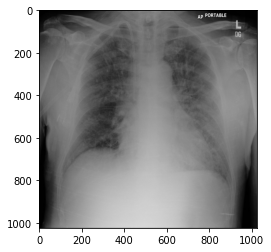

In [ ]:
sample_patient_id = test_dcm_fps[0]
sample_img_path = os.path.join(images_folder, "{}.jpg".format(sample_patient_id))

plt.imshow(cv2.imread(sample_img_path))

**3. Prepare Configuration Files for Using YOLOv3**

- We should prepare and modify config files, and bring pre-trained weights necessary for training. This proceeds with following four steps.

  - cfg/rsna.data
  - cfg/rsna.names
  - darknet53.conv.74
  - cfg/rsna_yolov3.cfg_train
  - cfg/rsna.data: This file point to RSNA data path

- train: Path to training image list textfile
- valid: Path to validation image list textfile
- names: RSNA class name list
- backup: A directory where trained weights(checkpoints) will be stored as training progresses.

In [ ]:
data_extention_file_path = os.path.join(config_folder, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_folder, "train_list.txt"),
               os.path.join(metadata_folder, "val_list.txt"),
               os.path.join(config_folder, 'rsna.names'),
               backup_folder)
    f.write(contents)

In [ ]:
!cat cfg/rsna.data

classes= 1
train  = /content/darknet/metadata/train_list.txt
valid  = /content/darknet/metadata/val_list.txt
names  = /content/darknet/cfg/rsna.names
backup = /content/darknet/backup
    

In [ ]:
# Label list of bounding box.
!echo "pneumonia" > cfg/rsna.names

- darknet53.conv.74 (Download Pre-trained Model)

  - For training, we would download the pre-trained model weights(darknet53.conv.74) using following wget command. The pre-trained weights are used in different fields of image recognition.

In [ ]:
#Download Pre-trained model

!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
#Download a cfg file edited for RSNA.

!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

**4. Training YOLOv3**

**4.0. Training with Pre-trained CNN Weights (darknet53.conv.74)**
- However the training takes considerably long depending on your resources.

In [ ]:
#!./darknet detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

**4.1. Plots of Training Loss**

- It's a loss graph up to about 2000 iterations.
- When learning, It will start with large losses and gradually improve.

In [ ]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=1OhnlV3s7r6xsEme6DKkNYjcYjsl-C_Av" -O train_log.txt

(0.0, 4.05)

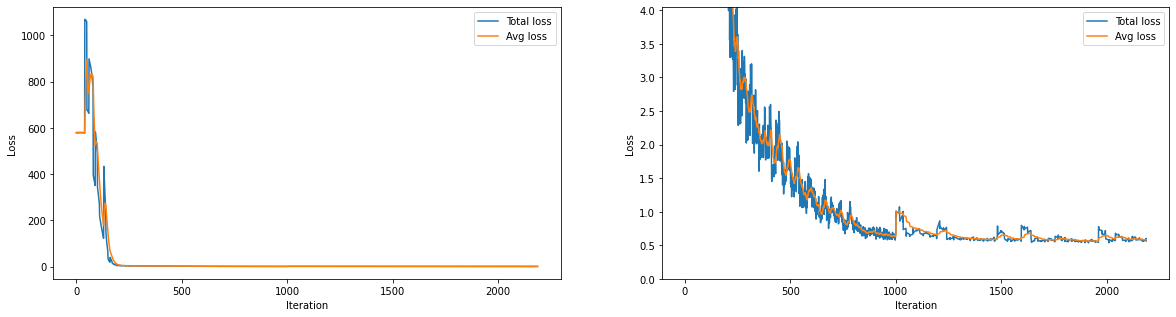

In [ ]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="Total loss")
sns.lineplot(iters, losses, label="Avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="Total loss")
sns.lineplot(iters, losses, label="Avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])

**5. Trainined YOLOv3 for test images**
- Copy sample test image

In [ ]:
ex_patient_id = image_annotation[image_annotation.Target == 1].patientId.values[2]
shutil.copy(sample_img_path, "./images/011d6083-abaa-4b28-8a53-36aa0cddb3b5.jpg")
print(sample_patient_id)

23ebfb85-2312-4a8b-8879-3cf48a1e8920


**5.1. Load trained model (at 15300 iterations)**

- It's a weight file at 15300 iterations.

In [ ]:
!wget --load-cookies /tmp/cookies.txt -q "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd" -O backup/rsna_yolov3_15300.weights && rm -rf /tmp/cookies.txt

In [ ]:
!ls -alsth backup

total 235M
235M -rw-r--r--  1 root root 235M Mar 18 08:36 rsna_yolov3_15300.weights
4.0K drwxr-xr-x 16 root root 4.0K Mar 18 08:36 ..
4.0K drwxr-xr-x  2 root root 4.0K Mar 18 08:17 .


**5.2. cfg file for testing**

In [ ]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

**Detection using a Pre-Trained Model**

In [ ]:
!./darknet detector test ./cfg/rsna.data ./cfg/rsna_yolov3.cfg_test ./backup/rsna_yolov3_15300.weights ./images/011d6083-abaa-4b28-8a53-36aa0cddb3b5.jpg -thresh 0.005

#!./darknet detector test ./cfg/rsna.data ./cfg/rsna_yolov3.cfg_test ./yolov3.weights ./images/011d6083-abaa-4b28-8a53-36aa0cddb3b5.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

**Predictions**

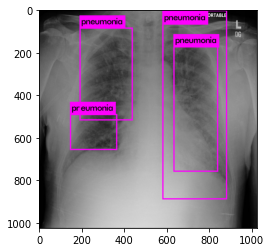

In [ ]:
#Plot the prediction with the position of Lung Inflammation

plt.imshow(cv2.imread("predictions.jpg"))

**6. Future work**

- Image augmentation
- More training
- Utilizing the unlabeled images